In [9]:
%%html
<style>div.input{display:none} div.output_stderr{display:none}</style>

# Kaplan-Meier
[Usage README: Github](https://github.com/dlanier/notebooks_KnowEnG/blob/master/docs/Kaplan_Meier.md)

In [10]:
%pylab notebook
import pylab

from   IPython.display import clear_output
from   lifelines import KaplanMeierFitter
from   lifelines.statistics import multivariate_logrank_test

from   knpackage import toolbox as kn
sys.path.insert(1, '../notebooks_KnowEnG/src')
from   layout_notebooks import *

results_dir = USER_RESULTS_DIRECTORY
input_data_dir = USER_DATA_DIRECTORY
clear_output()

In [11]:
get_km_file_button              = get_select_view_file_button_set(input_data_dir)

DEFAULT_DATA_FILE = 'Kaplan_Meijer_data.tsv'
DEFAULT_OUTPUT_FILE_NAME = 'Kaplan_Meier_Plot.png'
def reset_phenotype_cols_list(change):
    """ update the phenotype id options and select the first one in phenotype_id_listbox, and...
        update the category_select_listbox options and select the first
    """
    if get_km_file_button.file_selector.value == LIST_BOX_UPDATE_MESSAGE:
        if get_km_file_button.description == 'Clear':
            get_km_file_button.view_box.value = ''
            get_km_file_button.view_box.description = ''
            get_km_file_button.description = 'View'
        refresh_files_list(get_km_file_button)

        return
    options_df = kn.get_spreadsheet_df(os.path.join(input_data_dir, get_km_file_button.file_selector.value))
    sorted_options_list = sorted(list(options_df.columns.values))
    if len(sorted_options_list) > 0:
        def_val = sorted_options_list[0]
    else:
        def_val = ''
    cluster_id_listbox.options = sorted_options_list
    cluster_id_listbox.value = def_val
    event_id_listbox.options = sorted_options_list
    event_id_listbox.value = def_val
    time_id_listbox.options = sorted_options_list
    time_id_listbox.value = def_val

""" - the first shows the list of phenotype ids COUPLED TO the phenotype file selection """
cluster_id_listbox = widgets.Dropdown(options=[''],
                                        value='',
                                        description='Cluster_ID')

event_id_listbox = widgets.Dropdown(options=[''],
                                        value='',
                                        description='event')

time_id_listbox = widgets.Dropdown(options=[''],
                                        value='',
                                        description='time')

get_km_file_button.file_selector.observe(reset_phenotype_cols_list, names='value')

def disp_kaplan_meier(phenotype_df, cluster_id_name, event_name, time_name, button):
    T = phenotype_df[time_name]
    C = phenotype_df[event_name]
    
    results = multivariate_logrank_test(T, phenotype_df[cluster_id_name], C, alpha=0.99)
    p_value_string = '\n\t multivariate_logrank_test\np_value %g'%(results.p_value)
    button.view_box.value = p_value_string
    
    Clusters     = sorted(phenotype_df[cluster_id_name].unique())
    num_clusters = len(Clusters)
    
    figsize(12,6)
    ax     = subplot(111)
    
    ytitle = event_name
    xtitle = time_name

    kmf = KaplanMeierFitter()
    for cluster in Clusters:
        ixc = phenotype_df[cluster_id_name] == cluster
        kmf.fit ( T.ix[ixc], C.ix[ixc]         , label=cluster+1 )
        kmf.plot( ax=ax    , show_censors=True, ci_show=False    )

    plt.title ('number of clusters = %s' %(num_clusters))
    plt.xlabel('Time (days)'                            )
    plt.ylabel('OS'                                     )
    pylab.savefig(os.path.join(results_dir, DEFAULT_OUTPUT_FILE_NAME))
    
def run_kaplan_meier(button):
    """ callback for kaplan_meier_execute_button """
    if get_km_file_button.file_selector.value == LIST_BOX_UPDATE_MESSAGE:
        if get_km_file_button.description == 'Clear':
            get_km_file_button.view_box.value = ''
            get_km_file_button.view_box.description = ''
            get_km_file_button.description = 'View'
        refresh_files_list(get_km_file_button)
        
        return
    
    if button.description == 'Clear':
        button.description = button.original_description
        button.view_box.value = ''
        plt.clf()
        return
    else:
        button.description = 'Clear'
        
    phenotype_df = kn.get_spreadsheet_df(os.path.join(input_data_dir, get_km_file_button.file_selector.value))
    cluster_id_name = button.cluster_id_listbox.value
    event_name = button.event_id_listbox.value
    time_name = button.time_id_listbox.value

    disp_kaplan_meier(phenotype_df, cluster_id_name, event_name, time_name, button)

kaplan_meier_execute_button     = get_single_file_execute_button(
                                    input_data_dir, 
                                    results_dir, 
                                    file_selector=get_km_file_button.file_selector, 
                                    button_name='Plot',
                                    )
kaplan_meier_execute_button.original_description = kaplan_meier_execute_button.description
kaplan_meier_execute_button.view_box = get_view_box()
kaplan_meier_execute_button.cluster_id_listbox = cluster_id_listbox
kaplan_meier_execute_button.event_id_listbox = event_id_listbox
kaplan_meier_execute_button.time_id_listbox = time_id_listbox

if os.path.isfile(os.path.join(input_data_dir, DEFAULT_DATA_FILE)):
    get_km_file_button.file_selector.value = DEFAULT_DATA_FILE
    reset_phenotype_cols_list('de nada')
    kaplan_meier_execute_button.cluster_id_listbox.value = 'ClusterID'
    kaplan_meier_execute_button.event_id_listbox.value = 'event'
    kaplan_meier_execute_button.time_id_listbox.value = 'time'
    
kaplan_meier_execute_button.on_click(run_kaplan_meier)

# display control widgets
show_select_view_button(get_km_file_button)
show_widget_left(widgets.VBox([cluster_id_listbox,
                         event_id_listbox,
                         time_id_listbox,
                        ]))

Box(children=(Dropdown(index=7, layout=Layout(width='50%'), options=('average_labels.tsv', 'average_spreadsheet.tsv', 'descriptive_statistic_spreadsheet.tsv', 'Hsap.nbs_OV.G.gene_som_mut.binary.a.df', 'Hsap.nbs_UCEC.G.gene_som_mut.binary.a.df', 'intersect_spreadsheet_A.tsv', 'intersect_spreadsheet_B.tsv', 'Kaplan_Meijer_data.tsv', 'merge_spreadsheet_A.txt', 'merge_spreadsheet_B.txt', 'other_transforms_spreadsheet.tsv', 'select_phenotype_phenotype.txt', 'select_phenotype_spreadsheet.df', 'select_rows_list.txt', 'select_rows_spreadsheet.tsv', 'transpose_spreadsheet.tsv', 'View == Update List'), value='Kaplan_Meijer_data.tsv'), Button(description='View', style=ButtonStyle(), tooltip='visualize selected file')), layout=Layout(align_items='stretch', border='none', display='inline-flex', flex_flow='row', justify_content='space-between', width='100%'))

HTML(value='')

HBox(children=(VBox(children=(Dropdown(description='Cluster_ID', options=('ClusterID', 'eomthsdicunpal', 'event', 'mehpalctunisod', 'mupacnodtliseh', 'ntolihpsdeacmu', 'pdiuhascltnoem', 'seahiocndtlpum', 'sihnmldoepcaut', 'snauhdplotcmei', 'time', 'ulmsicpdnthaeo', 'utohdasipcnlme'), value='ClusterID'), Dropdown(description='event', index=2, options=('ClusterID', 'eomthsdicunpal', 'event', 'mehpalctunisod', 'mupacnodtliseh', 'ntolihpsdeacmu', 'pdiuhascltnoem', 'seahiocndtlpum', 'sihnmldoepcaut', 'snauhdplotcmei', 'time', 'ulmsicpdnthaeo', 'utohdasipcnlme'), value='event'), Dropdown(description='time', index=10, options=('ClusterID', 'eomthsdicunpal', 'event', 'mehpalctunisod', 'mupacnodtliseh', 'ntolihpsdeacmu', 'pdiuhascltnoem', 'seahiocndtlpum', 'sihnmldoepcaut', 'snauhdplotcmei', 'time', 'ulmsicpdnthaeo', 'utohdasipcnlme'), value='time'))),), layout=Layout(display='flex', flex_flow='row', justify_content='flex-start', width='100%'))

HBox(children=(Button(description='Plot', style=ButtonStyle(), tooltip='execute selected file'),), layout=Layout(display='flex', flex_flow='row', justify_content='flex-end', width='100%'))

HTML(value='')

<IPython.core.display.Javascript object>


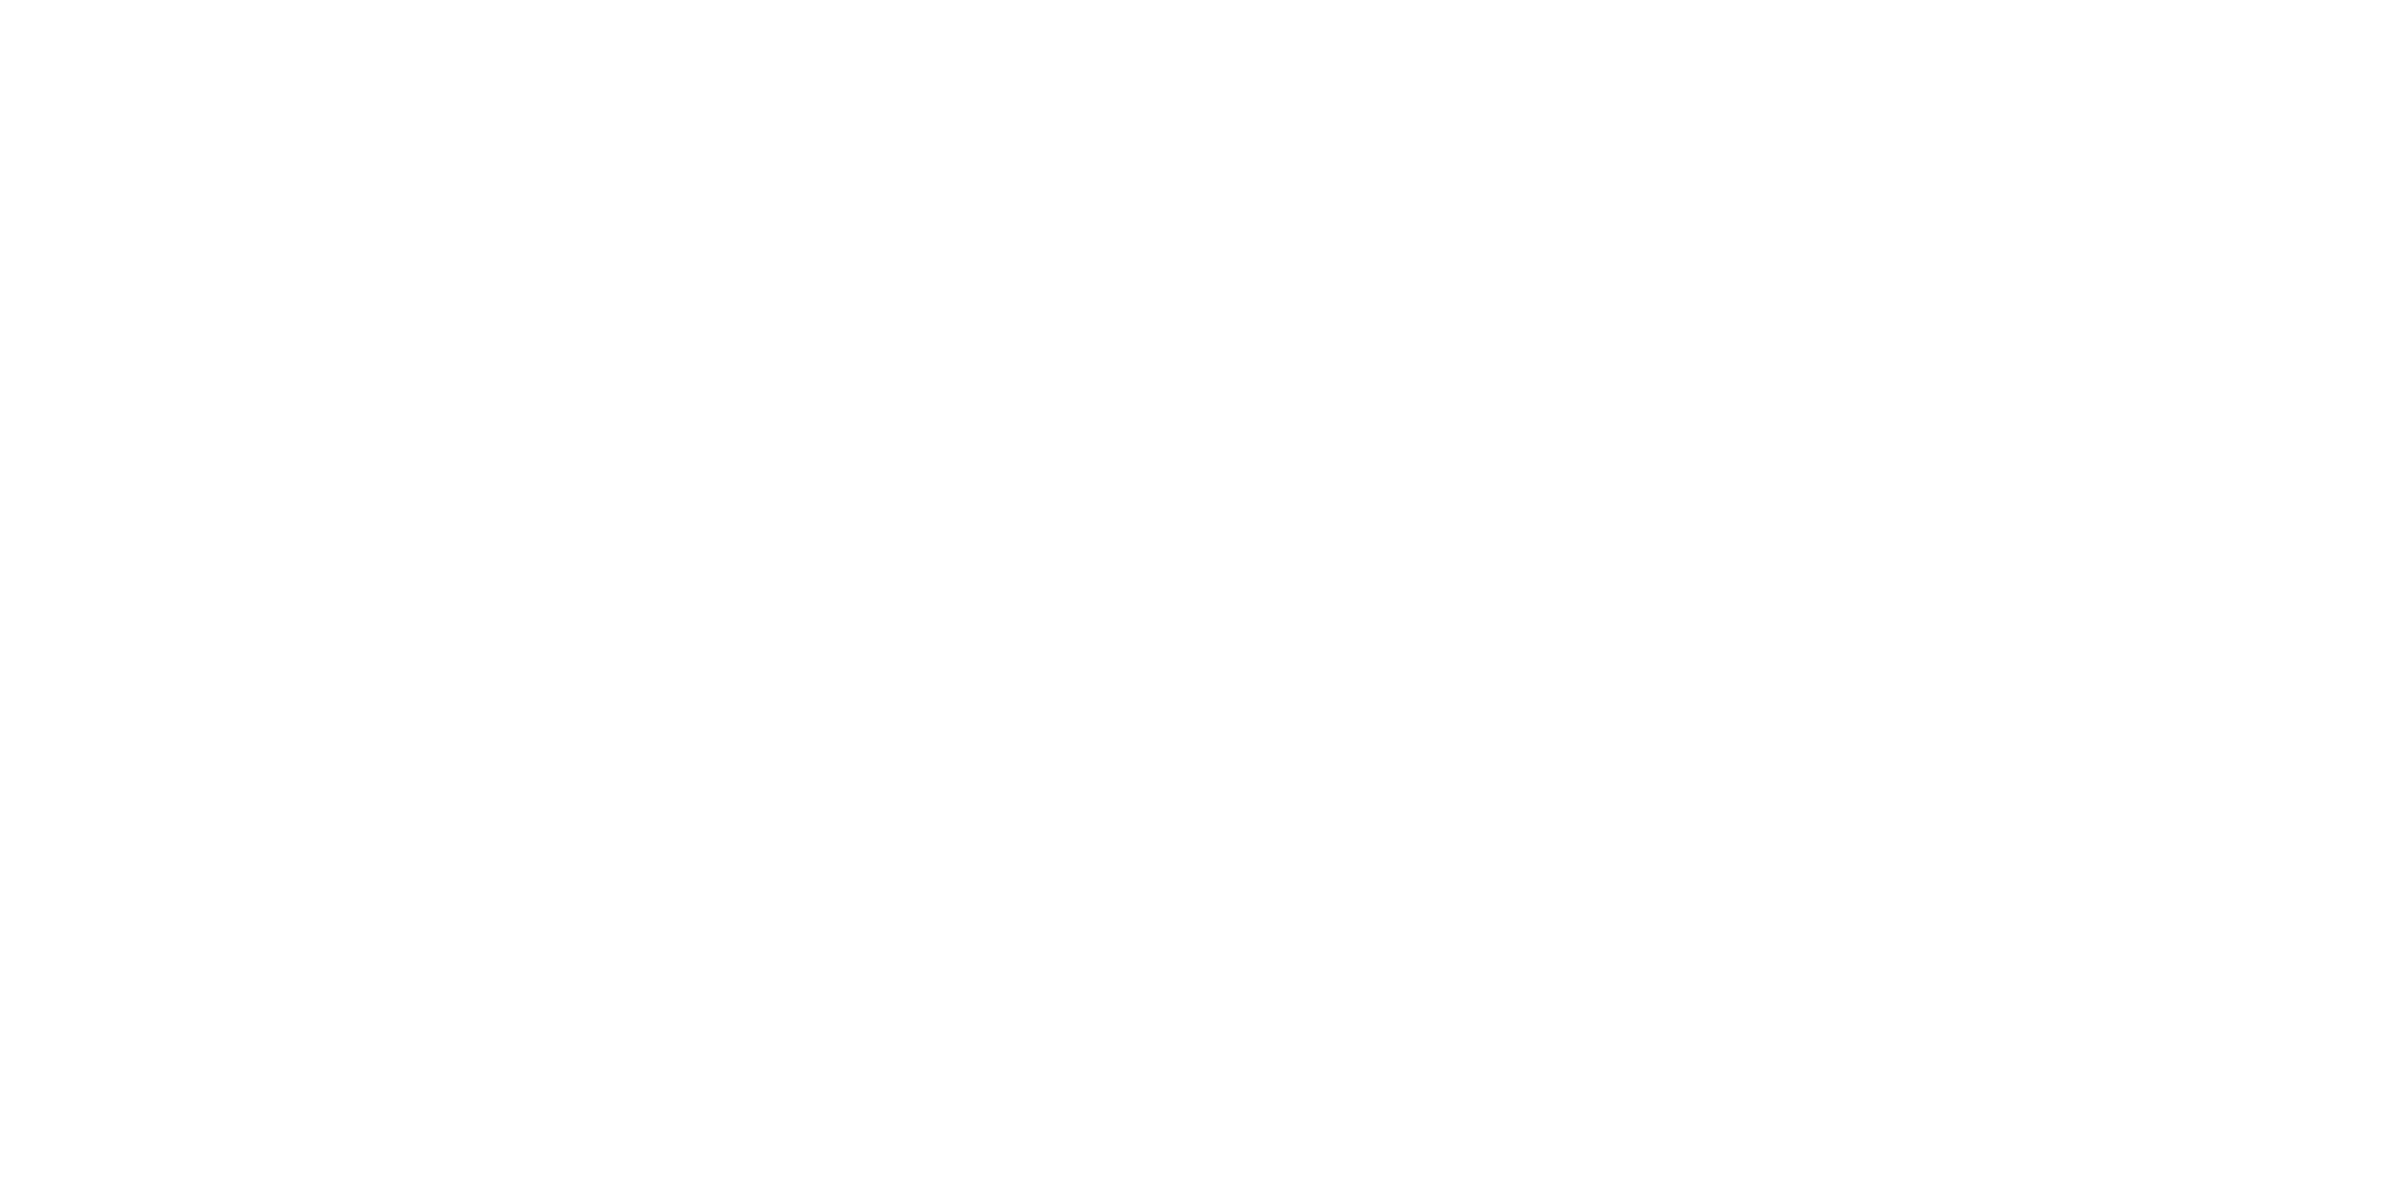

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:65: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [12]:
show_execute_button(kaplan_meier_execute_button)